In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

from utils import Logger

In [2]:
def mnist():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, 
                          transform=compose, download=True)

data = mnist()

data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=100, 
                                          shuffle=True)

num_batches = len(data_loader)

In [3]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [4]:
class discriminator(torch.nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [5]:
class generator(torch.nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [6]:
def noise(size):
    return Variable(torch.randn(size, 100))

In [7]:
d = discriminator()
g = generator()

d_optimizer = optim.Adam(d.parameters(), lr=0.0002)
g_optimizer = optim.Adam(g.parameters(), lr=0.0002)

loss = nn.BCELoss()

In [8]:
def ones_target(size):
    return Variable(torch.ones(size, 1))

def zeros_target(size):
    return Variable(torch.zeros(size, 1))

In [9]:
def train_d(optimizer, real_data, fake_data):
    N = real_data.size(0)
    
    # Resets the gradients
    optimizer.zero_grad()
    
    # Real data
    prediction_real = d(real_data)
    error_real = loss(prediction_real, ones_target(N))
    error_real.backward()
    
    # Fake data
    prediction_fake = d(fake_data)
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # Update weights
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

In [10]:
def train_g(optimizer, fake_data):
    N = fake_data.size(0)
    
    # Resets the gradients
    optimizer.zero_grad()
    
    # Fake data prediction
    prediction = d(fake_data)
    
    # Backprop
    error = loss(prediction, ones_target(N))
    error.backward()
    
    # Updates weights
    optimizer.step()
    
    return error

In [11]:
num_test_samples = 16
test_noise = noise(num_test_samples)

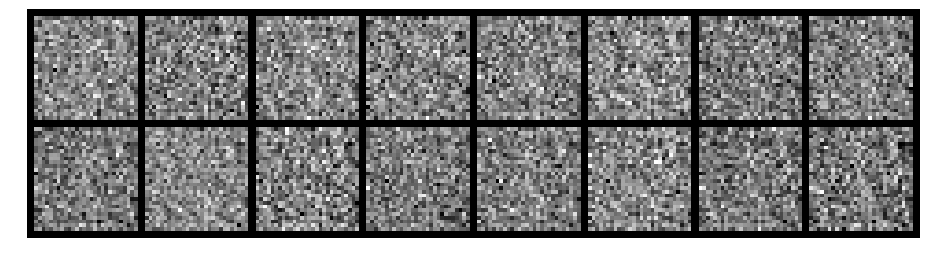

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3858, Generator Loss: 0.6566
D(x): 0.5199, D(G(z)): 0.5187


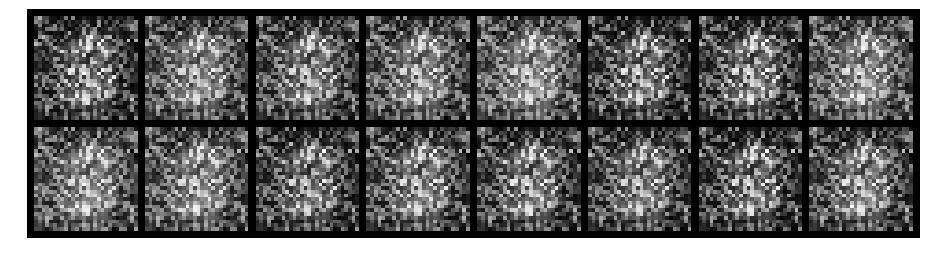

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.4866, Generator Loss: 1.1135
D(x): 0.7916, D(G(z)): 0.6676


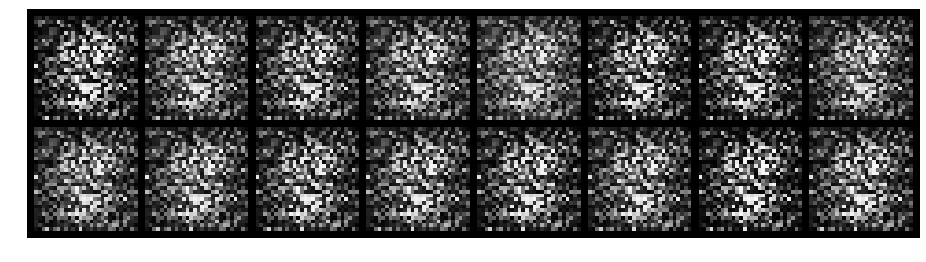

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 1.2426, Generator Loss: 1.8510
D(x): 0.7800, D(G(z)): 0.4562


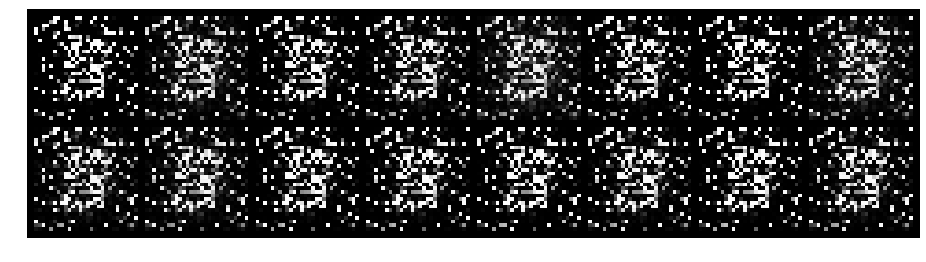

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.1615, Generator Loss: 6.3391
D(x): 0.9197, D(G(z)): 0.0445


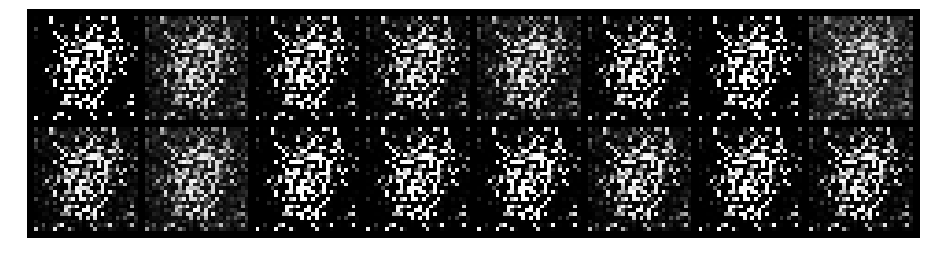

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.2003, Generator Loss: 6.9375
D(x): 0.9279, D(G(z)): 0.0521


In [ ]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')

# Total number of epochs to train
num_epochs = 200

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))

        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = g(noise(N)).detach()

        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_d(d_optimizer, real_data, fake_data)

        # 2. Train Generator

        # Generate fake data
        fake_data = g(noise(N))

        # Train G
        g_error = train_g(g_optimizer, fake_data)

        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(g(test_noise))
            test_images = test_images.data

            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )